Part A: Python EDA & Trends

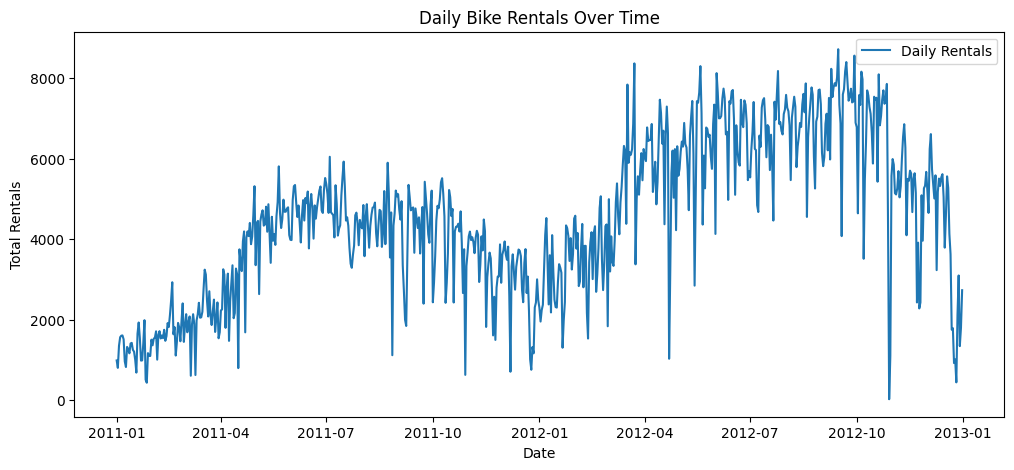

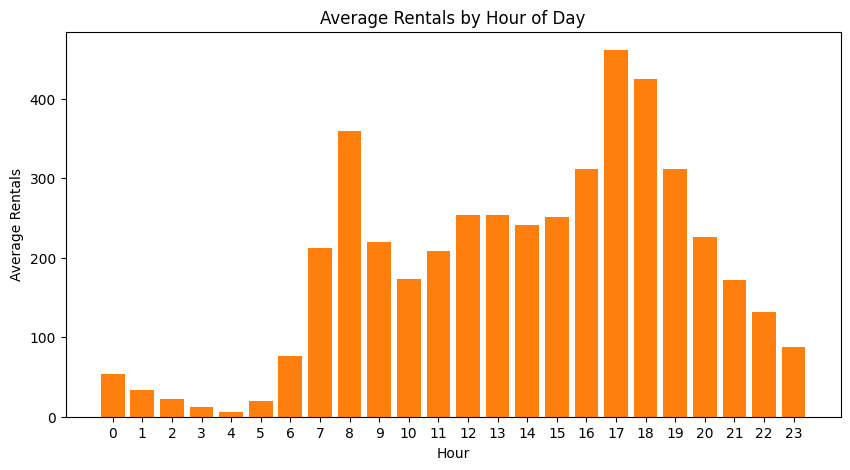

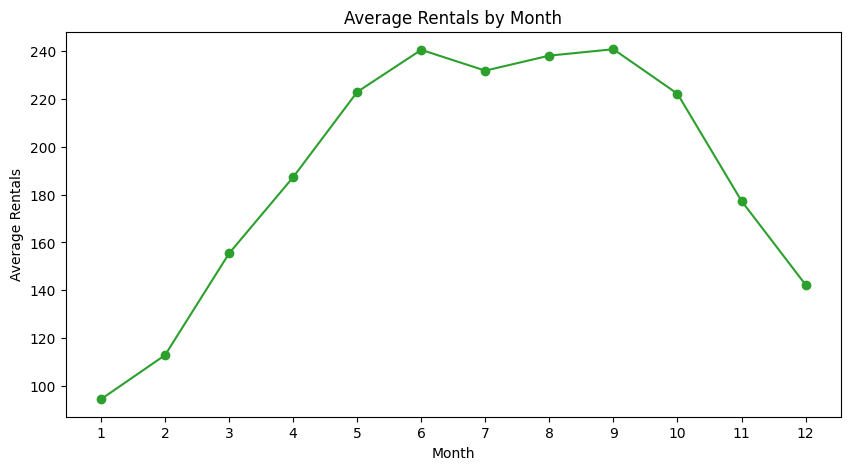

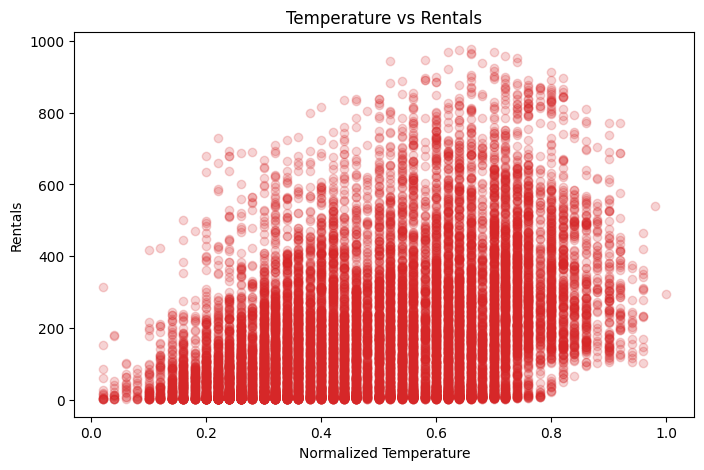

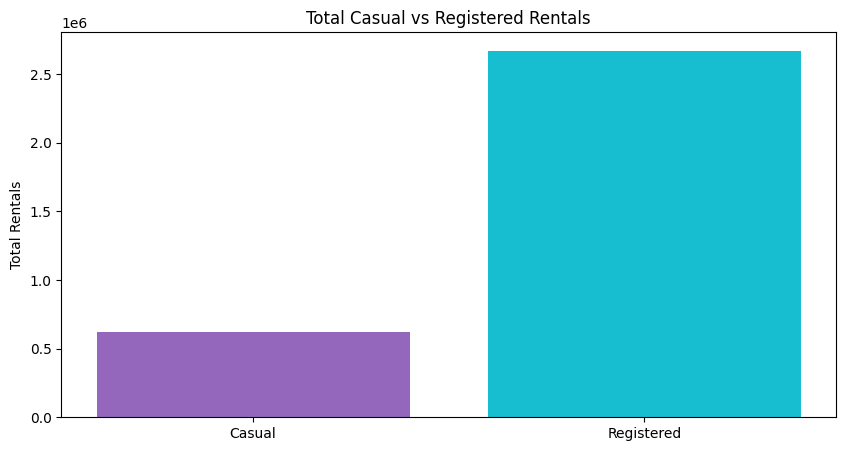

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/Users/gabriel/Desktop/marcy/Mod4Project/Data/hour.csv")

# Convert date column
df['dteday'] = pd.to_datetime(df['dteday'])

# 1. Daily trend: rentals over time
daily = df.groupby('dteday')['cnt'].sum()

plt.figure(figsize=(12,5))
plt.plot(daily.index, daily.values, label="Daily Rentals", color="tab:blue")
plt.title("Daily Bike Rentals Over Time")
plt.xlabel("Date")
plt.ylabel("Total Rentals")
plt.legend()
plt.show()

# 2. Hourly pattern: average rentals by hour of day
hourly = df.groupby('hr')['cnt'].mean()

plt.figure(figsize=(10,5))
plt.bar(hourly.index, hourly.values, color="tab:orange")
plt.title("Average Rentals by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Rentals")
plt.xticks(range(0,24))
plt.show()

# 3. Seasonal variation: average rentals by month
monthly = df.groupby('mnth')['cnt'].mean()

plt.figure(figsize=(10,5))
plt.plot(monthly.index, monthly.values, marker="o", color="tab:green")
plt.title("Average Rentals by Month")
plt.xlabel("Month")
plt.ylabel("Average Rentals")
plt.xticks(range(1,13))
plt.show()

# 4. Weather effect: temperature vs rentals
plt.figure(figsize=(8,5))
plt.scatter(df['temp'], df['cnt'], alpha=0.2, color="tab:red")
plt.title("Temperature vs Rentals")
plt.xlabel("Normalized Temperature")
plt.ylabel("Rentals")
plt.show()

# 5. Casual vs Registered comparison
plt.figure(figsize=(10,5))
plt.bar(["Casual", "Registered"], [df['casual'].sum(), df['registered'].sum()],
        color=["tab:purple","tab:cyan"])
plt.title("Total Casual vs Registered Rentals")
plt.ylabel("Total Rentals")
plt.show()


● Describe your top 3 trends/insights and explain why they matter
to PM/Ops/Marketing

A couple trends seen on this data is the summer is when the bike rentals are the most active, late afternoon is more populated for hours in a day (from 5 to 6 pm), and depending on how relatively high the temperature is outside, it causes rentals to rise in profit. 

These trends/insights matter for the Project Manager as it allows for them to understand when demand is strong and needed based on the frequency of rental profits.


Part B: Hypothesis Testing (Testing 1)

● What stakeholder would care about this test?

I would say the Product Manager. They need to understand whether commuting patterns differ on workdays vs weekends/holidays to optimize bike availability, rebalancing, and pricing strategies.

● How should you sample the data?

Compute the average hourly rides (cnt) grouped by working day vs non-working day. (So working day == 1, non-working == 0)

● What are the hypotheses, what alpha would you choose and why, how
would you explain the result (be sure to include confidence intervals)

H0 is workingday = non-workingday (average hourly rides do not differ)

H1 is workingday ≠ non-workingday (average hourly rides do differ from each other)

For the alpha it would be 0.05. This balances Type I (false alarm) and Type II (missed effect) errors appropriately for an operational/business decision.

Run a two sample t-test.

In [9]:
from scipy import stats
import statsmodels.stats.api as sms

work = df.loc[df['workingday'] == 1, 'cnt']
nonwork = df.loc[df['workingday'] == 0, 'cnt']

m_work, m_nonwork = work.mean(), nonwork.mean()
diff = m_work - m_nonwork

# Welch’s t-test
t_stat, p_val = stats.ttest_ind(work, nonwork, equal_var=False)

# 95% CI
cm = sms.CompareMeans(sms.DescrStatsW(work), sms.DescrStatsW(nonwork))
ci_low, ci_high = cm.tconfint_diff(alpha=0.05, usevar='unequal')

print("Mean Workingday:", m_work)
print("Mean Non-working:", m_nonwork)
print("Diff (Work - Nonwork):", diff)
print("p-value (two-tailed):", p_val)
print("95% CI:", (ci_low, ci_high))


Mean Workingday: 193.20775389801938
Mean Non-working: 181.40533188248097
Diff (Work - Nonwork): 11.802422015538411
p-value (two-tailed): 4.249478377549554e-05
95% CI: (np.float64(6.152999263103877), np.float64(17.451844767972947))


Part B: Hypothesis Testing (Testing 2)

● What stakeholder would care about this test? Does this change what multi-level categorical variable you choose?

The Marketing Lead would benefit from this test. With this they could use seasonal data or even weather conditions. Choosing weather conditions would be better for its direct operational. 

● How should you sample the data?

Each row is an hourly record of total rides (cnt).

We group the data by weathersit (multi-level categorical variable with 3 or 4 categories depending on coding).

Then we compare mean hourly rides across these groups.

● What are the hypotheses, what alpha would you choose and why, how would you explain the result (be sure to include confidence intervals)

H0: Mean hourly rides are the same across all weather conditions

H1: At least one hourly rides differs 

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# One-way ANOVA: mean rides across weather conditions
model = ols('cnt ~ C(weathersit)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Post-hoc test if significant
tukey = pairwise_tukeyhsd(df['cnt'], df['weathersit'], alpha=0.05)

print(anova_table)
print(tukey)


                     sum_sq       df           F        PR(>F)
C(weathersit)  1.228503e+07      3.0  127.173869  1.734782e-81
Residual       5.594766e+08  17375.0         NaN           NaN
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
     1      2  -29.7038    0.0  -37.7909 -21.6166   True
     1      3    -93.29    0.0 -106.2676 -80.3123   True
     1      4 -130.5359 0.5886 -396.7534 135.6815  False
     2      3  -63.5862    0.0  -77.6067 -49.5658   True
     2      4 -100.8322 0.7649 -367.1025 165.4381  False
     3      4  -37.2459 0.9841 -303.7096 229.2177  False
--------------------------------------------------------


Part C: Simulated A/B Test

In [13]:
# analysis_pm_objective.py
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.api as sms

# --- Settings ---

RANDOM_SEED = 42
PRE_START = "2012-08-04"
PRE_END   = "2012-08-31"
POST_START= "2012-09-01"
POST_END  = "2012-09-28"
PRACTICAL_THRESHOLD = 5.0   # rides/hour considered meaningful

df['dteday'] = pd.to_datetime(df['dteday'])

# --- Eligibility filters ---
elig = df[
    (df['workingday'] == 1) &
    (df['hr'].isin([17,18,19])) &
    (df['weathersit'].isin([1,2])) &
    (df['hum'] <= 0.70)
].copy()

# --- Window slices ---
pre = elig[(elig['dteday'] >= pd.to_datetime(PRE_START)) & (elig['dteday'] <= pd.to_datetime(PRE_END))].copy()
post = elig[(elig['dteday'] >= pd.to_datetime(POST_START)) & (elig['dteday'] <= pd.to_datetime(POST_END))].copy()

# --- Create slot key (weekday x hour) for stratified balancing ---
pre['slot'] = pre['weekday'].astype(str) + "_" + pre['hr'].astype(str)
post['slot'] = post['weekday'].astype(str) + "_" + post['hr'].astype(str)

# --- Stratified truncation: keep same count per slot in both groups ---
np.random.seed(RANDOM_SEED)
slots = sorted(list(set(pre['slot']).union(set(post['slot']))))

pre_kept = []
post_kept = []
for s in slots:
    pre_s = pre[pre['slot'] == s]
    post_s = post[post['slot'] == s]
    n_keep = min(len(pre_s), len(post_s))
    if n_keep == 0:
        continue
    pre_kept.append(pre_s.sample(n=n_keep, random_state=RANDOM_SEED))
    post_kept.append(post_s.sample(n=n_keep, random_state=RANDOM_SEED))

pre_trunc = pd.concat(pre_kept).reset_index(drop=True) if pre_kept else pd.DataFrame(columns=pre.columns)
post_trunc = pd.concat(post_kept).reset_index(drop=True) if post_kept else pd.DataFrame(columns=post.columns)

# --- Balance checks ---
def balance_table(df_group):
    return df_group.groupby(['weekday','hr']).size().unstack(fill_value=0)

bal_pre = balance_table(pre_trunc)
bal_post = balance_table(post_trunc)
weather_pre = pre_trunc['weathersit'].value_counts().sort_index()
weather_post = post_trunc['weathersit'].value_counts().sort_index()

# --- Summary stats ---
nA = len(pre_trunc)
nB = len(post_trunc)
mA = pre_trunc['cnt'].mean() if nA>0 else np.nan
mB = post_trunc['cnt'].mean() if nB>0 else np.nan
diff = mB - mA

# --- Statistical test (Welch's t-test) ---
t_stat, p_two = stats.ttest_ind(post_trunc['cnt'], pre_trunc['cnt'], equal_var=False)
cm = sms.CompareMeans(sms.DescrStatsW(post_trunc['cnt']), sms.DescrStatsW(pre_trunc['cnt']))
ci_low, ci_high = cm.tconfint_diff(alpha=0.05, usevar='unequal')

# --- Guardrail summaries (example metrics) ---
guard = pd.DataFrame({
    'metric': ['mean_cnt','mean_registered','mean_casual','mean_hum','mean_temp'],
    'pre': [
        pre_trunc['cnt'].mean(),
        pre_trunc['registered'].mean(),
        pre_trunc['casual'].mean(),
        pre_trunc['hum'].mean(),
        pre_trunc['temp'].mean()
    ],
    'post':[
        post_trunc['cnt'].mean(),
        post_trunc['registered'].mean(),
        post_trunc['casual'].mean(),
        post_trunc['hum'].mean(),
        post_trunc['temp'].mean()
    ]
})

# --- Print results ---
print("=== Group sizes ===")
print("Pre  (nA):", nA)
print("Post (nB):", nB)
print()
print("=== Means (cnt) ===")
print("Pre mean (mA):", round(mA,3))
print("Post mean (mB):", round(mB,3))
print("Observed diff (Post - Pre):", round(diff,3))
print()
print("=== Welch t-test (two-sided) ===")
print("t-statistic:", round(t_stat,4))
print("two-sided p-value:", round(p_two,6))
print("95% CI for diff (Post - Pre):", (round(ci_low,3), round(ci_high,3)))
print()
print("Practical threshold (>=):", PRACTICAL_THRESHOLD,
      "=>", "practically significant" if diff >= PRACTICAL_THRESHOLD else "not practically significant")
print()
print("=== Balance tables (Pre) ===")
print(bal_pre)
print()
print("=== Balance tables (Post) ===")
print(bal_post)
print()
print("=== Weather mix ===")
print("Pre weathersit counts:\n", weather_pre.to_string())
print("Post weathersit counts:\n", weather_post.to_string())
print()
print("=== Guardrail summary (means) ===")
print(guard.to_string(index=False))


=== Group sizes ===
Pre  (nA): 46
Post (nB): 46

=== Means (cnt) ===
Pre mean (mA): 744.783
Post mean (mB): 788.565
Observed diff (Post - Pre): 43.783

=== Welch t-test (two-sided) ===
t-statistic: 1.5672
two-sided p-value: 0.120604
95% CI for diff (Post - Pre): (np.float64(-11.725), np.float64(99.29))

Practical threshold (>=): 5.0 => practically significant

=== Balance tables (Pre) ===
hr       17  18  19
weekday            
1         3   2   2
2         3   2   3
3         3   3   3
4         4   4   3
5         4   4   3

=== Balance tables (Post) ===
hr       17  18  19
weekday            
1         3   2   2
2         3   2   3
3         3   3   3
4         4   4   3
5         4   4   3

=== Weather mix ===
Pre weathersit counts:
 weathersit
1    37
2     9
Post weathersit counts:
 weathersit
1    41
2     5

=== Guardrail summary (means) ===
         metric        pre       post
       mean_cnt 744.782609 788.565217
mean_registered 640.326087 700.804348
    mean_casual 104.4565

Additional Visuals 

/var/folders/cs/x0q13b6514sbl5vlbl495zxc0000gn/T/ipykernel_3940/3830994937.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="hr", y="cnt", hue="workingday", estimator="mean", ci=None)


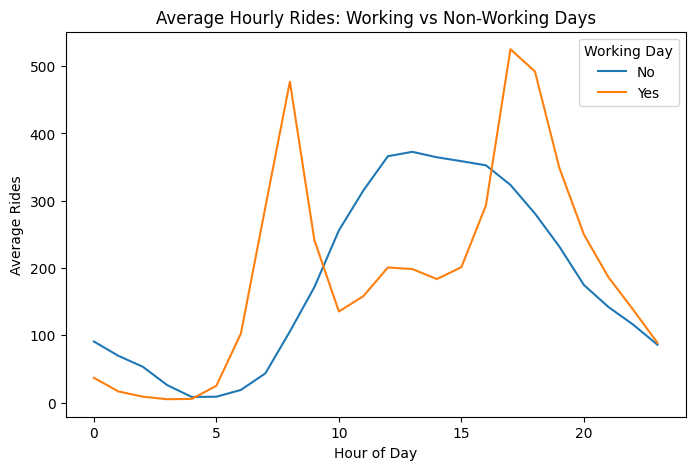

/var/folders/cs/x0q13b6514sbl5vlbl495zxc0000gn/T/ipykernel_3940/3830994937.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups, x="Period", y="cnt", palette="Set2")


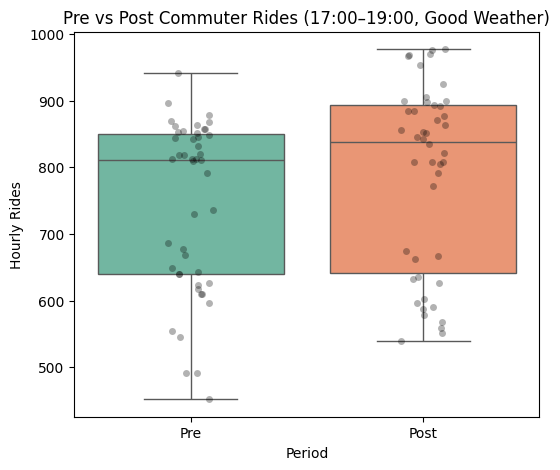

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Hourly pattern by working day
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x="hr", y="cnt", hue="workingday", estimator="mean", ci=None)
plt.title("Average Hourly Rides: Working vs Non-Working Days")
plt.xlabel("Hour of Day")
plt.ylabel("Average Rides")
plt.legend(title="Working Day", labels=["No", "Yes"])
plt.show()

# 2. Pre vs Post commuter rides
groups = pd.DataFrame({
    "Period": ["Pre"]*len(pre_trunc) + ["Post"]*len(post_trunc),
    "cnt": pd.concat([pre_trunc['cnt'], post_trunc['cnt']])
})

plt.figure(figsize=(6,5))
sns.boxplot(data=groups, x="Period", y="cnt", palette="Set2")
sns.stripplot(data=groups, x="Period", y="cnt", color="black", alpha=0.3)
plt.title("Pre vs Post Commuter Rides (17:00–19:00, Good Weather)")
plt.ylabel("Hourly Rides")
plt.show()
